In [1]:
from netgen.meshing import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
sys.path.append('..\model')
from BathPlateModel import BathPlateModel

model=BathPlateModel(holes=2, outerBox="box", boxx=0.2, boxy=0.2, boxz=0.2, msize=meshsize.coarse)
DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)

Bath Plate Model    holes: 2    Thickness: 0.00635
boxx=  0.2  boxy=  0.2  boxz=  0.2
div_thick=  1
name: conductor   mass: 2.6669999999999994e-05   center: (0, 2.1808e-20, -2.46491e-21)
name: air   mass: 0.00017348625000000007   center: (0, -4.55112e-19, 2.91247e-20)
name: reduced_region   mass: 0.06379984375000002   center: (0, -1.44176e-19, 9.03322e-20)
conductive_region: conductor
Conductor boundary: conductor_boundary
{'conductor': 32780000.0, 'air': 0, 'reduced_region': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 'reduced_region': 1.2566370614359173e-06, 'default': 1.2566370614359173e-06}
class HolePot: num= 0  holes
class MeasureFace: num= 0  faces


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

enter iccg_solve
Dof= 199748    matrix size= 9347701.5
shift parameter= 1.06
minimum residual= 8.508494154929479e-09  at iteraions:  95


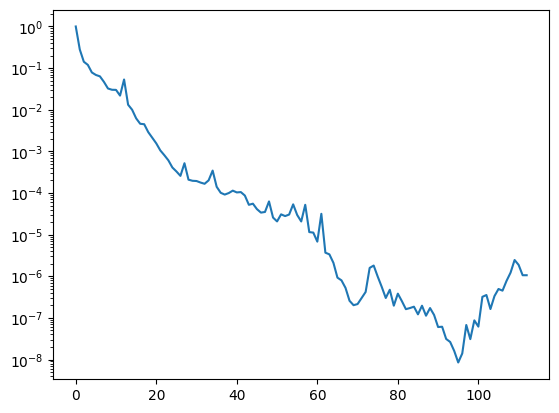

結果のノルム: 4.41532260002286e-07
power=  (0.06047298853893606-0.001589684740386918j)
center magnetic field =  ((0.004616049949418708-0.00022444385587750678j), (-7.317979817915628e-07-4.653755778540673e-06j), (0.007163878698460773-0.0016924510010832025j))


In [2]:
import math
feorder=4
Dirichlet=False
jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
    
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductive_region=model.conductive_region

coil=model.coil.field
#coil=UNIF(0,0,0.01,0)
Av=Afield(coil)
Bv=Bfield(coil)
mu=4.e-7*math.pi
Hv=Bv/mu
As=model.ReducedField(Av, (0,0,0))
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane+'|'+reduced_boundary, nograds=True, complex=jomega)
else:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane, nograds=True, complex=jomega) 
fesPhi=H1(mesh, order=feorder, definedon=conductive_region, complex=jomega) 
fesAPhi=fesA*fesPhi
(A,phi), (N, psi) = fesAPhi.TnT() 
gfAPhi = GridFunction(fesAPhi)
gfA, gfPhi=gfAPhi.components
normal = specialcf.normal(mesh.dim)

a= BilinearForm(fesAPhi)
a +=1/Mu*curl(A)*curl(N)*dx
a +=s*Sigma*(A+grad(phi))*(N+grad(psi))*dx(conductive_region)
with TaskManager():
    a.Assemble()

# Calculate Dirichlet condition terms
gfA.Set(Av, BND, mesh.Boundaries(total_boundary))
f = LinearForm(fesAPhi)
f +=1/Mu*curl(gfA)*curl(N)*dx(reduced_region)

with TaskManager():
    f.Assemble()    
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesAPhi.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesAPhi.FreeDofs()] = fcut

# Add Neumann condition terms
f += Cross(N.Trace(),Hv)*normal*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfAPhi= GridFunction(fesAPhi)   #Clear gfA
gfA, gfPhi=gfAPhi.components
gfAPhi=solver.iccg_solve(fesAPhi, gfAPhi, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=jomega, logplot=True) 

fesAt=HCurl(mesh, order=feorder, definedon=total_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
fesAr=HCurl(mesh, order=feorder, definedon=reduced_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
At=GridFunction(fesAt)
Arr=GridFunction(fesAr)
Axr=GridFunction(fesAr)
At.Set(gfA,VOL, definedon=total_region)
Arr.Set(gfA,VOL, definedon=reduced_region)
Axr.Set(Av, BND, mesh.Boundaries(total_boundary))

Bt=curl(At)
Ar=Arr-Axr
Br=curl(Arr)-curl(Axr)

Afield=At+Ar+As
Bfield=Bt+Br+Bs
Jfield=-s*Sigma*(At+grad(gfPhi))
   
mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))


In [3]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region), mesh)
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  0.24966984833631964


In [4]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [5]:
from netgen.occ import OCCGeometry
from ngsolve.comp import Mesh
from netgen.meshing import meshsize
plotMesh=Mesh(OCCGeometry(model.conductor).GenerateMesh(meshsize.coarse)).Curve(1)
#plotMesh=mesh
if jomega==True:
    Draw (Jfield.real, plotMesh, order=feorder, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, plotMesh, order=feorder, deformation=False) 
else:
    print("****** Jfield ******")
    Draw (Jfield, plotMesh, order=feorder, deformation=False) 

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

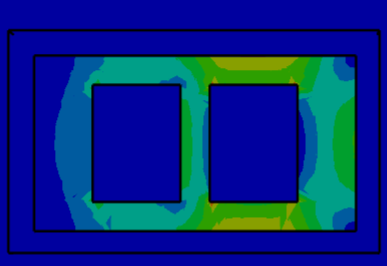
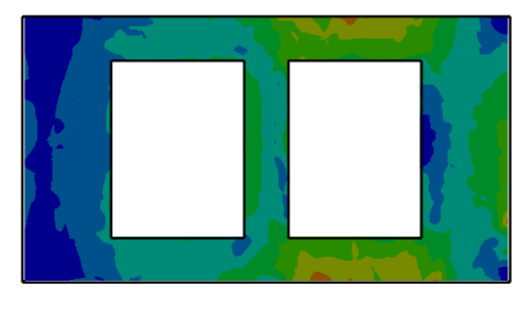

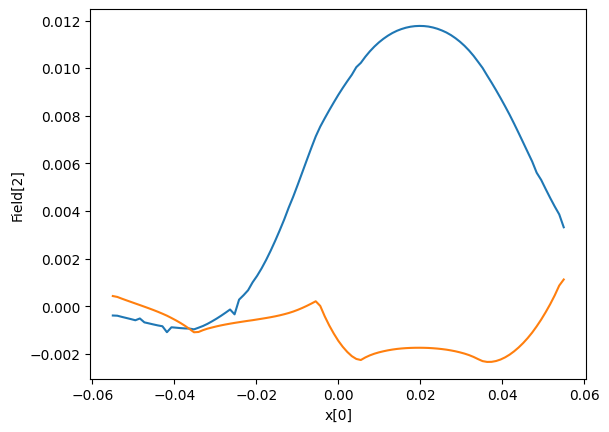

In [6]:
from netgen.occ import * 
from FieldPlot import FieldPlot 
xs=gp_Pnt(-0.055, 0, 6.35e-3/2+0.5e-3)
xe=gp_Pnt(0.055, 0, 6.35e-3/2+0.5e-3)
line = Segment(xs, xe)
FieldPlot(mesh, Bfield, line, 0, 2, 100)

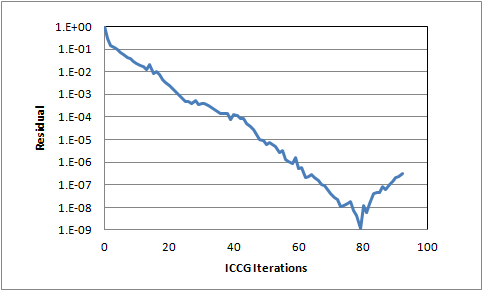

Average Joule loss=  0.24944676713674657

B field real [0,004]
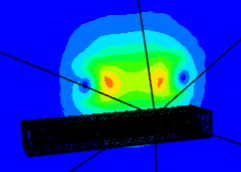

B field imag [0, 0.001]
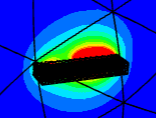

center magnetic field =  ((0.004596513687080331-0.00028974502149362323j), (3.907432126622281e-06+1.2447518645942504e-05j), (0.00711920890384394-0.001787441788297481j))

J field real [0,2e6]
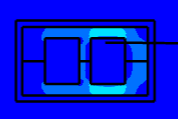

J field imag [0,2e6]
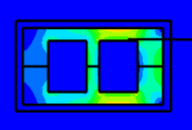

No hole, feOrder=3, Dirichlet=False, 0.01T unform field

Jz real [0, 1e6]
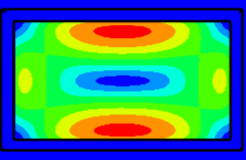
Jz imag [0, 2e6] 
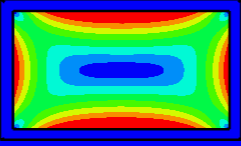

Average Joule loss=  1.0897375183846068

Apply Coil field, 　Dirichlet=True, feOrder=3

J field real [0, 5e5]
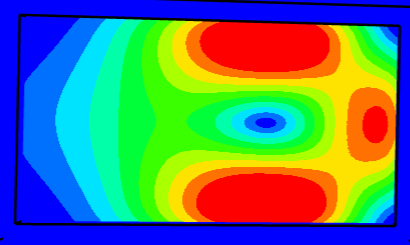

J field imag [0, 2e6]
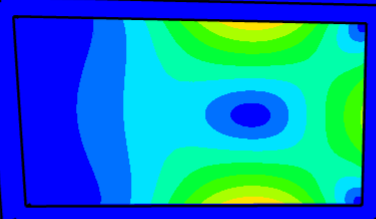

Average Joule loss=  0.3486242392846813

UNIF  0.01T, jomega=False, Dirichlet=False, 2 Holes

Average Joule loss=  1.1662163486441814

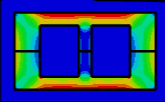